# Introducing Quantum Functions with Quantum Monte Carlo Integration

This tutorial explains how to write custom quantum functions with Classiq and subsequently uses them for more complex functions or algorithms. This is illustrated on a specific use case of Quantum Monte Carlo Integration (QMCI). The example below demonstrates how we can exploit various concepts of modeling quantum algorithms with Classiq when building our own functions.

## QMCI

We start with a brief introduction to the quantum algorithm treated in this tutorial.

Monte Carlo integration refers to estimating expectation values of a function $f(x)$, where $x$ is a random variable drawn from some known distribution $p$:

\begin{equation}
\tag{1}
E_{p}(x) = \int f(x)p(x) dx.
\end{equation}
Such evaluations appear in the context of option pricing or credit risk analysis.

The basic idea of QMCI assumes that we have a quantum function $A$, which, for a given $f$ and $p$, loads the following state of $n+1$ qubits:
\begin{align}
\tag{2}
A|0\rangle_n|0\rangle = \sum^{2^n-1}_{i=0} \sqrt{f_i} \sqrt{p_i}|i\rangle_n|1\rangle + \sum^{2^n-1}_{i=0} \sqrt{1-f_i} \sqrt{p_i}|i\rangle_n|0\rangle = \sqrt{a}|\psi_1\rangle+\sqrt{1-a^2}|\psi_0\rangle,
\end{align}
where it is understood that the first $2^n$ states represent a discretized space of $x$, and that $0\leq f(x)\leq 1$.
Then, by applying the amplitude estimation (AE) algorithm for the "good-state" $|\psi_1 \rangle$, we can estimate its amplitude:
$$
a = \sum^{2^n-1}_{i=0} f_i p_i.
$$

The QMCI algorithm can be separated into two parts:
1) Constructing a Grover operator for the specific problem. This is done here almost from scratch.
2) Applying the AE algorithm based on the Grover operator [[1](#AE)]. This is done by calling the Classiq Quantum Phase Estimation (QPE) function.

### Specific Use Case for the Tutorial

For simplicity we consider a simple use case. We take a probability distribution on the integers
$$
\tag{3}
p_i = \frac{i}{\mathcal{N}} \text{ for } i\in \{0,\dots 2^3-1\},
$$
where $\mathcal{N}$ is a normalization constant, and we would like to evaluate the expectation value of the function
$$
\tag{4}
f(x) = \sin^2(0.25x+0.2).
$$
Therefore, the value we want to evaluate is
$$
a= \frac{1}{\mathcal{N}} \sum^7_{k=0} \sin^2(0.25k+0.2) k \approx 0.834.
$$

## 1. Building the Corresponding Grover Operator 

### Quantum Functions

This example demonstrates how to define Qmod functions by writing a Python function decorated with the `@qfunc` decorator.
The typical workflow for defining a quantum function:
1. Specifying the function signature: The `@qfunc` decorator relies on Python's type-hint mechanism to extract the signature of the Qmod function from the argument list of the Python function.
2. Specifying the function body: To construct the body of the Qmod function, the Python interpreter executes a function decorated with `@qfunc`. Inside, you can do one of these:
    - Call other `@qfuncs` to insert the corresponding quantum function calls into the body of the resulting Qmod function
    - Introduce local quantum variables by instantiating a quantum type
    - Use arithmetic and in-place assignment operators to insert special quantum statements into the function
    

We can start with relevant imports:

In [1]:
import matplotlib.pyplot as plt

from classiq import *

### Grover Operator for QMCI

The Grover operator suitable for QMCI is defined as follows:
$$
Q\equiv - S_{\psi_1} A^{\dagger} S_0 A,
$$
with $S_0$ and $S_{\psi_1}$ being reflection operators around the zero state $|0\rangle_n|0\rangle$ and the good-state $|\psi_1\rangle$, respectively, and the function $A$ is defined in Eq. ([2](#mjx-eqn-2)).

In subsections (1.1)-(1.3) below we build each of the quantum sub-functions, and then in subsection (1.4) we combine them to define a complete Grover operator. On the way we introduce several concepts of functional modeling, which allow the Classiq synthesis engine to reach better optimized circuits. 

#### 1.1) The State Loading $A$ Function

We start with constructing the $A$ operator in Eq. ([2](#mjx-eqn-2)). We define a quantum function and give it the name `state_loading`.

The function's signature declares two arguments: 
1. A quantum register `io` declared as `QArray[QBit]` (an array of qubits with an unspecified size) that is used to represent the discretization of space.
2. A quantum register `ind` of size 1 declared as `QBit` to indicate the good state. 

Next, we construct the logic flow of the `state_loading` function. 
The function body consists of two quantum function calls:

1. As can be seen from Eq. ([2](#mjx-eqn-2)), the `load_probabilities` function is constructed using the Classiq `inplace_prepare_state` function call on $n=3$ qubits with probabilities $p_i$. 
2. The `amplitude_loading` body calls the Classiq `linear_pauli_rotations` function. The `linear_pauli_rotations` loads the amplitude of the function $ f(x) = sin^2(0.25 x + 0.2) $.

    *Note: The amplitude should be $sin$ so the probability is $sin^2$.*

    The function uses an auxiliary qubit that is utilized so that the desired probability reflects on the auxiliary qubit if it is in the `|1>` state.

    We use the function with the Pauli Y matrix and enter the appropriate slope and offset to achieve the right parameters.


We define the probabilities according to the specific problem described by Eqs. ([3](#mjx-eqn-3)-[4](#mjx-eqn-4)).

In [2]:
import numpy as np

sp_num_qubits = 3
probabilities = np.linspace(0, 1, 2**sp_num_qubits) / sum(
    np.linspace(0, 1, 2**sp_num_qubits)
)


slope = 0.5
offset = 0.4


@qfunc
def load_probabilities(state: QArray[QBit]):
    inplace_prepare_state(probabilities.tolist(), 0, state)


@qfunc
def amplitude_loading(io: QArray[QBit], ind: QBit):
    linear_pauli_rotations(
        bases=[Pauli.Y.value], slopes=[slope], offsets=[offset], x=io, q=ind
    )


@qfunc
def state_loading(io: QArray[QBit], ind: QBit):
    load_probabilities(io)
    amplitude_loading(io=io, ind=ind)

To examine our function we define a quantum `main` function from which we can build a model, synthesize, and view the quantum program created:

In [3]:
@qfunc
def main(res: Output[QArray[QBit]], ind: Output[QBit]):
    allocate(sp_num_qubits, res)
    allocate(1, ind)
    state_loading(res, ind)


model = create_model(main)
qprog = synthesize(model)
show(qprog)

Opening: https://platform.classiq.io/circuit/2utyWdWW3Ee1XaTcsshbUgQOtKf?login=True&version=0.73.0
https://platform.classiq.io/circuit/2utyWdWW3Ee1XaTcsshbUgQOtKf?login=True&version=0.73.0


#### 1.2) $S_{\psi_1}$ Function - The Good State Oracle

The next quantum function we define is the one that reflects around the good state: any $n+1$ state in which the `ind` register is at state $|1\rangle$. This function can be constructed with a ZGate on the `ind` register. 


In [4]:
@qfunc
def good_state_oracle(ind: QBit):
    Z(ind)

#### 1.3) $S_{0}$ Function - The Grover Diffuser

To implement the Grover Diffuser we aim to perform a controlled-Z operation on the $|0>^n$ state.

We can define a `zero_oracle` quantum function with the `io` and `ind` registers as its arguments. 

The `within_apply` operator takes two function arguments—compute and action—and invokes the sequence `compute()`, `action()`, and `invert(compute())`. Quantum objects that are allocated and prepared by compute are subsequently uncomputed and released.

The `control` condition is a logical expression over a quantum variable. Currently, expressions are restricted to the form `<var> == <classical-expression>`, where both `<var>` and `<classical-expression>` are integer types.

In [5]:
@qfunc
def prepare_minus(q: QBit):
    X(q)
    H(q)


@qfunc
def zero_oracle(x: QNum, ind: QBit):
    within_apply(lambda: prepare_minus(ind), lambda: control(x == 0, lambda: X(ind)))

We can verify that
\begin{eqnarray}
|00\dots0\rangle \xrightarrow[{\rm ctrl(-Z)(target=q_0, ctrl=q_1\dots q_n)}]{} -|00\dots0\rangle, \\
|10\dots0\rangle \xrightarrow[{\rm ctrl(-Z)(target=q_0, ctrl=q_1\dots q_n)}]{} |10\dots0\rangle, \\
|11\dots0\rangle \xrightarrow[{\rm ctrl(-Z)(target=q_0, ctrl=q_1\dots q_n)}]{} |11\dots0\rangle,\\
|11\dots1\rangle \xrightarrow[{\rm ctrl(-Z)(target=q_0, ctrl=q_1\dots q_n)}]{} |11\dots1\rangle,
\end{eqnarray}
which is exactly the functionality we want.



#### 1.4) $Q$ Function - The Grover Operator

We can now define a complete Grover operator $Q\equiv -S_{\psi_1} A^{\dagger} S_0 A$. We do this in a single code block that calls the following:
1. The good state oracle (`good_state_oracle`)
2. THe inverse of the state preparation (`state_loading`)
3. The diffuser (`zero_oracle`)
4. The state preparation (`state_loading`)
 
*Note:*
- *Stages 2-4 are implemented by utilizing the `within_apply` operator*  
- *We add a global phase of -1 to the full operator by using the atomic gate level function `U`*

In [6]:
@qfunc
def my_grover_operator(state: QArray[QBit]):
    io = QArray[QBit]("io", length=state.len - 1)
    ind = QBit("ind")
    bind(state, [ind, io])
    good_state_oracle(ind=ind)
    within_apply(
        lambda: invert(lambda: state_loading(io=io, ind=ind)),
        lambda: zero_oracle(io, ind),
    )
    U(0, 0, 0, np.pi, ind)
    bind([ind, io], state)

##### Let us look at the `my_grover_operator` function we created:

In [7]:
@qfunc
def main(state: Output[QArray[QBit]]):
    io = QArray[QBit]("io")
    ind = QBit("ind")
    allocate(sp_num_qubits, io)
    allocate(1, ind)
    bind([ind, io], state)
    my_grover_operator(state)


model_2 = create_model(main)
qprog_2 = synthesize(model_2)
show(qprog_2)

Opening: https://platform.classiq.io/circuit/2utyXUISizsuT6oISqEt85IWt1P?login=True&version=0.73.0
https://platform.classiq.io/circuit/2utyXUISizsuT6oISqEt85IWt1P?login=True&version=0.73.0


## 2. Applying Amplitude Estimation (AE) with Quantum Phase Estimation (QPE)

Here we apply a basic AE algorithm that is based on QPE. The idea behind this algorithm is the following:

The state $A|0\rangle_n|0\rangle$ is spanned by two eigenvectors of our Grover operator $Q$, with the two corresponding eigenvalues
\begin{equation}
\tag{5}
\lambda_{\pm}=\exp\left(\pm i2\pi \theta \right), \qquad \sin^2 \left(\pi \theta\right)\equiv a.
\end{equation}
Therefore, if we apply a QPE on $A|0\rangle_n|0\rangle$, we have these two eigenvalues encoded in the QPE register. However, both give the value of $a$, so there is no ambiguity.

To find $a$ we build a simple quantum model, applying $A$ on a quantum register of size $n+1$ initialized to zero, and then applying the Classiq QPE with the `my_grover_operator` we defined.

Below is the `main` function from which we can build our model and synthesize it. In particular, we define the output register `phase` as `QNum` to hold the phase register output of the QPE. We choose a QPE with phase register of size 3, governing the accuracy of our phase-, and thus amplitude-, estimation. 

In [8]:
n_qpe = 3


@qfunc
def main(phase: Output[QNum]):
    io = QArray[QBit]("io")
    ind = QBit("ind")
    allocate(sp_num_qubits, io)
    allocate(1, ind)
    state_loading(io=io, ind=ind)
    state = QArray[QBit]("state")
    bind([ind, io], state)
    allocate_num(n_qpe, False, n_qpe, phase)
    qpe(unitary=lambda: my_grover_operator(state=state), phase=phase)
    bind(state, [ind, io])


model_3 = create_model(main)
model_3 = set_constraints(model_3, Constraints(max_width=9))
qprog_3 = synthesize(model_3)
show(qprog_3)

Opening: https://platform.classiq.io/circuit/2utyZICpP7SJ1NgJJuFWb7h6g8S?login=True&version=0.73.0
https://platform.classiq.io/circuit/2utyZICpP7SJ1NgJJuFWb7h6g8S?login=True&version=0.73.0


We can export our model to a `.qmod` file:

In [9]:
write_qmod(model, "qmc_user_defined", decimal_precision=10)

### Executing the Circuit and Measuring the Approximated Amplitude

We execute on a simulator:

In [10]:
result = execute(qprog_3).result_value()

We identify $|\lambda_0,\lambda_1\dots \lambda_{m-1}\rangle_m=\frac{1}{2^m}\sum^{m-1}_{i=0}\lambda_i 2^i$, whose mapping can be done as follows:

In [11]:
## mapping between register string to phases
phases_counts = dict(
    (sampled_state.state["phase"], sampled_state.shots)
    for sampled_state in result.parsed_counts
)

Upon plotting the resulting histogram we see two phase values with high probability (however, both correspond to the same amplitude $a$):

phase with max probability:  0.625


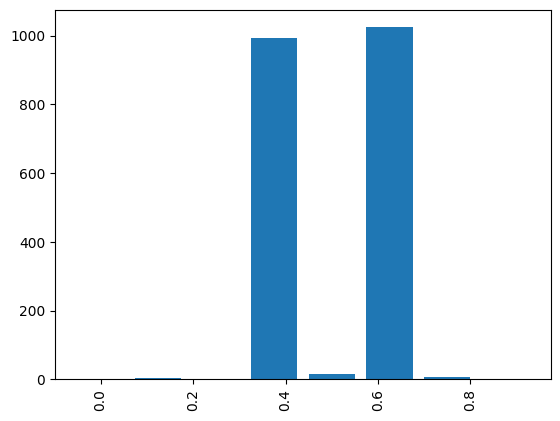

In [12]:
plt.bar(phases_counts.keys(), phases_counts.values(), width=0.1)
plt.xticks(rotation=90)
print("phase with max probability: ", max(phases_counts, key=phases_counts.get))

Recalling the relation in Eq. ([5](#mjx-eqn-5)), we can read the amplitude $a$ from the phase with maximum probability and compare to the expected amplitude:

In [13]:
print(
    "measured amplitude: ",
    np.sin(np.pi * max(phases_counts, key=phases_counts.get)) ** 2,
)
print(
    "exact amplitude: ",
    sum(np.sin(0.5 * n / 2 + 0.4 / 2) ** 2 * probabilities[n] for n in range(2**3)),
)

measured amplitude:  0.8535533905932737
exact amplitude:  0.8338393824876795


## References

<a name='AE'>[1]</a>: [Brassard, G., Hoyer, P., Mosca, M., & Tapp, A. (2002). Quantum Amplitude Amplification and Estimation. Contemporary Mathematics, 305, 53-74.](https://arxiv.org/abs/quant-ph/0005055)
